In [1]:
# All packages used in this notebook are imported here.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection, tree
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from scipy import stats
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from patsy.builtins import *
from patsy import dmatrices

#Jellyfish is not included in syzygy. Uncomment if necessary.
#!pip install jellyfish
import jellyfish as jf

In [2]:
# Prep data for prediction
def prep_data(df, continuous_variables, categories, y_var, test_size=0.15):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

# This function will allow us to compare the MSE's of each model
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

In [3]:
decision_data = pd.read_csv('Carp Manning with Attributes.csv')

# We only need some of this data
judge_decisions = decision_data[['Authoring Judge','Court Location','Number of Judges','Circuit','Year','Decision Ideology',
                                'Case Type','Case Category','Year of Appointment','Appointing President','Judge Party',
                                'Gender','Race','Year of Birth','ABA Rating','Congress','Unity']].copy()

# We begin by converting the decision ideology, which is either liberal or conservative, into a dummy.
def libcon_dummy(ideology):
    if ideology == 'Conservative':
        return 100
    if ideology == 'Liberal':
        return -100
    else:
        return np.nan
judge_decisions['Decision Ideology'] = judge_decisions['Decision Ideology'].apply(libcon_dummy)

# Here is what the data looks like
judge_decisions.head()

Authoring Judge    Court Location  Number of Judges      Circuit  Year  \
0    Avis, John Boyd        Camden, NJ                 1  3RD CIRCUIT  1932   
1    Avis, John Boyd        Camden, NJ                 1  3RD CIRCUIT  1932   
2    Strum, Louie W.  Jacksonville, FL                 1  5TH CIRCUIT  1932   
3  Moscowitz, Grover      Brooklyn, NY                 5  2ND CIRCUIT  1932   
4    Cochran, Andrew     Maysville, KY                 1  6TH CIRCUIT  1932   

   Decision Ideology                Case Type                 Case Category  \
0                100          alien petitions  Civil Liberties/Rights Cases   
1                100          alien petitions  Civil Liberties/Rights Cases   
2                100  (non)conv-criminal case        Criminal Justice Cases   
3                100   criminal court motions        Criminal Justice Cases   
4               -100            voting rights  Civil Liberties/Rights Cases   

   Year of Appointment Appointing President Judge Party Gender  \
0                 1929               HOOVER  Republican   male   
1                 1929               HOOVER  Republican   male   
2                 1931               HOOVER    Democrat   male   
3                 1925             COOLIDGE  Republican   male   
4                 1901             MCKINLEY  Republican   male   

              Race  Year of Birth ABA Rating Congress           Unity  
0  white/caucasian         1875.0  Not Rated     78TH         Unified  
1  white/caucasian         1875.0  Not Rated     78TH         Unified  
2  white/caucasian         1890.0  Not Rated     81ST  Divided, House  
3  white/caucasian         1886.0  Not Rated     80TH         Unified  
4  white/caucasian         1854.0  Not Rated     73RD         Unified

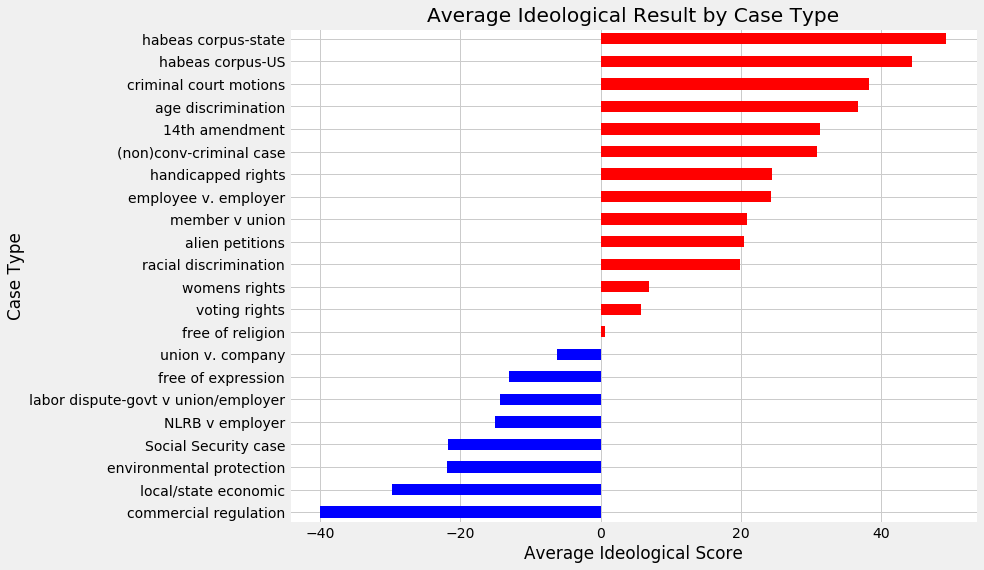

In [4]:
# Get the list of case types with more than 1000 cases
high_vol_types = judge_decisions[['Case Type','Authoring Judge']].groupby('Case Type').count().reset_index()
high_vol_types['High Vol'] = [1 if count >= 1000 else 0 for count in high_vol_types['Authoring Judge']]
high_vol_types = high_vol_types[high_vol_types['High Vol'] == 1]
high_vol_types = high_vol_types.drop(columns = ['Authoring Judge','High Vol'])

ideology_by_type = (judge_decisions[['Case Type','Decision Ideology']].groupby('Case Type')
                    .mean().sort_values('Decision Ideology').reset_index())
ideology_by_type = ideology_by_type.merge(high_vol_types, on = 'Case Type', how = 'right')

plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ax.set_title("Average Ideological Result by Case Type")
ax.set_xlabel("Average Ideological Score")
colors = ["b" if x < 0 else "r" for x in ideology_by_type['Decision Ideology'].values]

ideology_by_type.plot(kind = 'barh', x = 'Case Type', y = 'Decision Ideology', ax = ax, color = colors, legend = False)

Text(0, 0.5, 'Mean Decision Ideology Score')

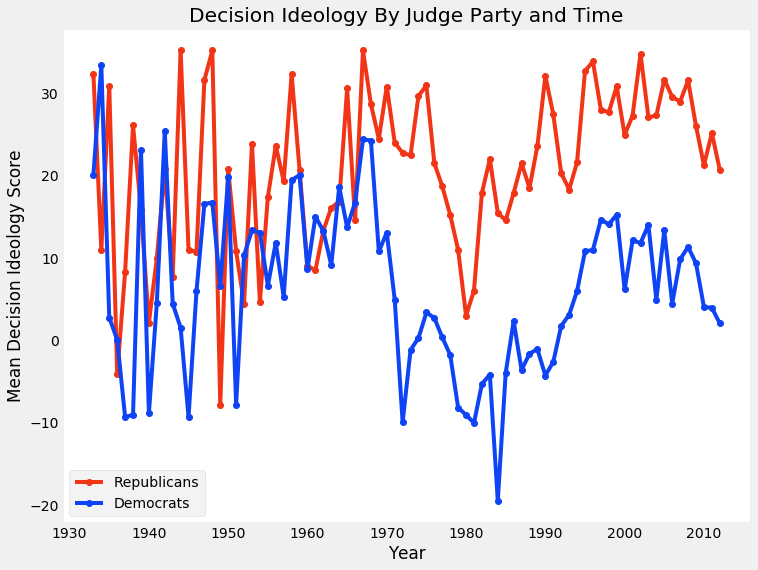

In [5]:
ideology_by_party_year = (judge_decisions[['Year','Judge Party','Decision Ideology']].groupby(['Year','Judge Party',])
                          .mean().reset_index())
ideology_by_party_year = ideology_by_party_year[(ideology_by_party_year['Judge Party'] == 'Democrat') |
                                                (ideology_by_party_year['Judge Party'] == 'Republican')]
# 1933 is first year where both parties are present
ideology_by_party_year = ideology_by_party_year[ideology_by_party_year['Year'] >= 1933]
democrats = ideology_by_party_year["Judge Party"] == "Democrat"
republicans = ideology_by_party_year["Judge Party"] == "Republican"

fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)

ax.plot(ideology_by_party_year[republicans]["Year"],
        ideology_by_party_year[republicans]["Decision Ideology"],"-o",label="Republicans",color="#f23417")

ax.plot(ideology_by_party_year[democrats]["Year"],
        ideology_by_party_year[democrats]["Decision Ideology"],"-o",label="Democrats",color="#0e44f5")

ax.legend()
ax.set_title("Decision Ideology By Judge Party and Time")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Decision Ideology Score")

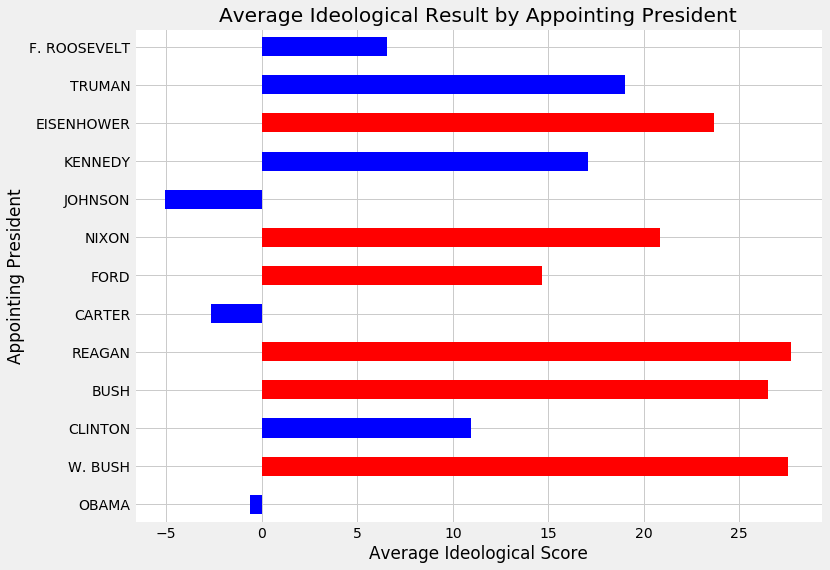

In [6]:
ideology_by_app_pres = (judge_decisions[judge_decisions['Year of Appointment']>=1933]
                        [['Appointing President','Decision Ideology']]
                        .groupby(['Appointing President'])
                        .mean().reset_index().reindex([9,12,2,0,10,1,5,8,6,7,3,11,4]))
fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ax.set_title("Average Ideological Result by Appointing President")
ax.set_xlabel("Average Ideological Score")
colors = ["b" if x in ['F. ROOSEVELT','TRUMAN','KENNEDY','JOHNSON','CARTER','CLINTON','OBAMA'] 
          else "r" for x in ideology_by_app_pres['Appointing President'].values]

ideology_by_app_pres.plot(kind = 'barh', x = 'Appointing President', y = 'Decision Ideology',
                          ax = ax, color = colors, legend = False)

In [7]:
ideology_by_gen_race = (judge_decisions[judge_decisions['Race'].isin(
                                        ['African-American/black','Asian-American','Latino/Hispanic','white/caucasian'])]
                       .pivot_table(index='Race', columns='Gender', values='Decision Ideology', margins=True))
ideology_by_gen_race

Gender                     female       male        All
Race                                                   
African-American/black   1.870748   5.016212   4.439944
Asian-American         -14.754098   5.413105   0.211416
Latino/Hispanic          5.091650  26.355388  24.271457
white/caucasian         12.628256  15.822735  15.497959
All                     10.976939  15.695166  15.190996

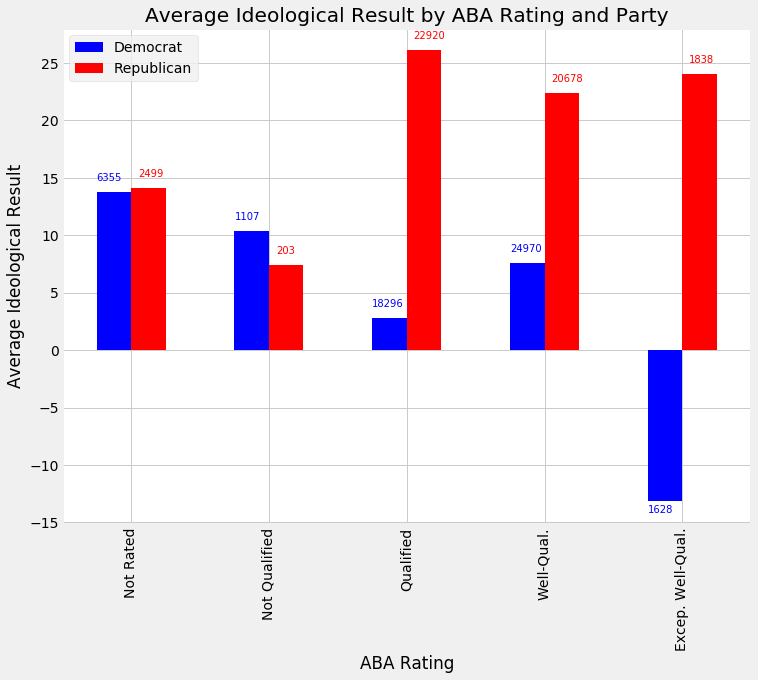

In [8]:
ideology_by_rating = (judge_decisions[judge_decisions['ABA Rating'].isin(
                                      ['Not Rated','Well-Qual.','Qualified','Not Qualified','Excep. Well-Qual.']) &
                                      judge_decisions['Judge Party'].isin(['Democrat','Republican'])]
                      .groupby(['ABA Rating','Judge Party'])[['Decision Ideology']].mean()
                      .unstack().reset_index().reindex([2,1,3,4,0]))
ideology_by_rating.columns = ['ABA Rating','Democrat','Republican']

# Add counts of each rating-party pair
count_by_rating = (judge_decisions[judge_decisions['ABA Rating'].isin(
                                      ['Not Rated','Well-Qual.','Qualified','Not Qualified','Excep. Well-Qual.']) &
                                      judge_decisions['Judge Party'].isin(['Democrat','Republican'])]
                      .groupby(['ABA Rating','Judge Party'])[['Decision Ideology']].count().unstack().reset_index())
count_by_rating.columns = ['ABA Rating','Democrat Count','Republican Count']
ideology_by_rating = ideology_by_rating.merge(count_by_rating, on = 'ABA Rating')

fig, ax = plt.subplots(figsize=(11,8.5))
ax.set_facecolor('white')
ax.grid(False)
ideology_by_rating.plot(kind = 'bar', x = 'ABA Rating', y = ['Democrat','Republican'], ax = ax, color =['b','r'])
ax.set_title("Average Ideological Result by ABA Rating and Party")
ax.set_ylabel("Average Ideological Result")
for i, v in enumerate(ideology_by_rating['Democrat'].values):
    text = ideology_by_rating[ideology_by_rating['Democrat'] == v]['Democrat Count'].iloc[0]
    if v > 0:
        ax.text(i - 0.25 , v + 1, text, color='b', fontdict = {'size': 10})
    else: 
        ax.text(i - 0.25 , v - 1, text, color='b', fontdict = {'size': 10})
for i, v in enumerate(ideology_by_rating['Republican'].values):
    text = ideology_by_rating[ideology_by_rating['Republican'] == v]['Republican Count'].iloc[0]
    if v > 0:
        ax.text(i + 0.05, v + 1, text, color='r', fontdict = {'size': 10})
    else: 
        ax.text(i + 0.05, v - 1, text, color='r', fontdict = {'size': 10})

# Analysis

In [9]:
decisions = decision_data[list(judge_decisions) + ['House Democrats','House Republicans','Senate Democrats',
                                                   'Senate Republicans','House Independents','Senate Independents',
                                                   'Recess Appointment']]
decisions = decisions.drop(columns = ['Authoring Judge'])
decisions = decisions.dropna()

In [10]:
# We begin by converting the decision ideology, which is either liberal or conservative, into a dummy.
def libcon_dummy(ideology):
    if ideology == 'Conservative':
        return 1
    if ideology == 'Liberal':
        return 0
    else:
        return np.nan
decisions['Decision Ideology'] = decisions['Decision Ideology'].apply(libcon_dummy)

In [11]:
categories_dec = ['Court Location', 'Circuit', 'Case Type', 'Case Category', 'Appointing President', 'Judge Party', 'Gender',
              'Race', 'ABA Rating', 'Congress', 'Unity', 'Recess Appointment']

# Categorical variables 
continuous_variables_dec = list(filter(lambda col: col not in categories_dec + ['Decision Ideology'], list(decisions)))

In [12]:
X_dec_train, X_dec_test, y_dec_train, y_dec_test = prep_data(
    decisions, continuous_variables_dec, categories_dec, 'Decision Ideology'
)

In [21]:
alphas = np.exp(np.linspace(-2., -12., 25))
lr_model = linear_model.LinearRegression(n_jobs = 100)
logistic_model = linear_model.LogisticRegression(solver="liblinear", max_iter = 1000, n_jobs = 100)
lasso_model = linear_model.LassoCV(cv=6, alphas = alphas,  max_iter=500, n_jobs = 100)
forest_model = RandomForestRegressor(n_estimators = 100, n_jobs = 100)
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((150,),activation = "logistic",
                                solver="adam",alpha=0.005)) # we tried a few alphas chose this one 
                                                            # based on minimizing mse_test ... but it was somewhat arbitrary
models = { "OLS": lr_model, "Logistic": logistic_model, "Lasso": lasso_model,
          "Random Forest": forest_model, "Neural Network":nn_scaled_model}

In [29]:
MSE_by_model = pd.DataFrame(index = models.keys(),
                            columns= ["Train MSE","Test MSE"])

In [23]:
ideo_mse_list = [fit_and_report_mses(model,X_dec_train, X_dec_test, y_dec_train, y_dec_test) for model in models.values()]

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 100.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

C:\Users\Ian\Anaconda3\lib\site-package

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



In [27]:
MSE_by_model['Train MSE'] = ['%f' % result["mse_train"] for result in ideo_mse_list]
MSE_by_model['Test MSE'] = ['%f' % result["mse_test"] for result in ideo_mse_list]
MSE_by_model

Train MSE              Test MSE
OLS             0.216954  3045509606943.511719
Logistic        0.348573              0.351613
Lasso           0.217721              0.219440
Random Forest   0.063205              0.240012
Neural Network  0.174729              0.230434